In [22]:
import os.path
import pandas as pd
import pandas_datareader.data as web
import requests
from datetime import datetime
from datetime import timedelta
import matplotlib
import matplotlib.pyplot as plt
import pyfolio as pf


now = datetime.now()
start = datetime.strptime("01-02-2014", "%m-%d-%Y")
start_conts = start
##base_url = 'http://ws.spk.gov.tr/PortfolioValues/api/PortfoyDegerleri/'

portfolio = pd.DataFrame({'Name': [],'Number': [],'Price': []})
backtrack = pd.DataFrame(index=pd.date_range(start, now, dtype='datetime64[ns]'), columns = ['MarketValue', 'Cost', 'ReturnSeries'])
backtrack = backtrack.fillna(0)
money = int(raw_input("Starting money:"))
eur = web.DataReader('TRY=X','yahoo', start_conts, now)['Adj Close']
money = money / eur[start_conts]
monthly_money = int(raw_input("Montly investment:"))
#Stock code list and their percentages.
code_list = []
code_list_perc = []
number_of_inputs = int(raw_input("Number of stocks:"))


for i in range(0,number_of_inputs):
    #Stock name and percentages
    stock_name = str(raw_input("Name of the stock:"))
    stock_percentage = float(raw_input("Stock percentage:"))
    code_list.append(stock_name)
    code_list_perc.append(stock_percentage)
    #Getting the initial stock variables.
    ##resp = requests.get(base_url + stock_name + "/2/" + "01-02-2014/01-02-2014")
    resp = web.DataReader(stock_name, 'yahoo', start, start)['Adj Close']
    ##eur = web.DataReader('TRY=X','yahoo', start, start)['Adj Close']
    for item in resp.iteritems():
        number_of_stocks = (stock_percentage * money) / (item[1])
        s = pd.Series([stock_name, number_of_stocks, item[1]], index = ['Name', 'Number', 'Price'])
    portfolio = portfolio.append(s, ignore_index=True)


Starting money:10000
Montly investment:0
Number of stocks:7
Name of the stock:VTI
Stock percentage:0.27
Name of the stock:VEA
Stock percentage:0.12
Name of the stock:VWO
Stock percentage:0.06
Name of the stock:VIG
Stock percentage:0.08
Name of the stock:XLE
Stock percentage:0.06
Name of the stock:SCHP
Stock percentage:0.06
Name of the stock:MUB
Stock percentage:0.35


In [24]:

portfolio['Value'] = portfolio.Number * portfolio.Price
#Determining the initial backtrack positions.
backtrack.ix[start, 'MarketValue'] = portfolio['Value'].sum()
backtrack.ix[start, 'Cost'] = portfolio['Value'].sum()
start = start + timedelta(days=1)
i = 0
for stock in code_list:
    ##start_date = datetime.strftime(start, '%m-%d-%Y')
    ##end_date = datetime.strftime(now, '%m-%d-%Y')
    ##second_base_url = base_url + stock + "/2/" + start_date + "/" + end_date
    ##response = requests.get(second_base_url, timeout=None)
    response = web.DataReader(stock, 'yahoo', start, now)['Adj Close']
    #Calculating the money for certain stock.
    money_for_stock = money * code_list_perc[i]
    stock_month = 1
    for item in response.iteritems():
        date_string = str(item[0]).split(" ")[0]
        my_date = datetime.strptime(date_string, "%Y-%m-%d")
        portfolio.ix[i,'Price'] = item[1]
        backtrack.ix[my_date, 'MarketValue'] += portfolio.ix[i,'Number'] * portfolio.ix[i,'Price']
        backtrack.ix[my_date, 'Cost'] += money_for_stock
        back_date = my_date - timedelta(days=1)

        #Doing the montly investment.
        if (my_date.month != stock_month):
            money_for_stock += monthly_money * code_list_perc[i]
            stock_month += 1
            if stock_month == 13 : stock_month = 1
            portfolio.ix[i,'Number'] += (monthly_money * code_list_perc[i]) / (item[1])
    #Increasing i for the next stocks percentage.
    i += 1

In [25]:
backtrack = backtrack[backtrack.MarketValue != 0]
backtrack = backtrack.dropna()
portfolio

Name     Number       Price        Value
0   VTI  14.022585  121.800003  1257.920239
1   VEA  14.962502   38.279999   559.075662
2   VWO   7.641669   38.689999   279.537831
3   VIG   5.335788   90.430000   372.717108
4   XLE   3.455471   71.379997   279.537831
5  SCHP   5.458240   55.520000   279.537831
6   MUB  16.880562  108.820000  1630.637346

In [26]:
eur = web.DataReader('TRY=X','yahoo', start_conts, now)['Adj Close']
eur = eur.reindex(backtrack.index.sort_values())
eur = eur.fillna(method = 'ffill')

In [27]:
backtrack['MarketValue'] = backtrack['MarketValue'] * eur

In [29]:
back_mv = backtrack.ix[start_conts, 'MarketValue']
back_cost =  backtrack.ix[start_conts, 'Cost']
for index, item in backtrack.iterrows():
    rt = (item["MarketValue"] / (back_mv + (item["Cost"] - back_cost))) - 1
    backtrack.ix[index,'ReturnSeries'] = rt
    back_mv = item['MarketValue']
    back_cost = item['Cost']

In [30]:
backtrack

MarketValue         Cost  ReturnSeries
2014-01-02  10000.000000  4658.963846      0.000000
2014-01-03  10105.051026  4658.963846      0.010505
2014-01-06  10120.681526  4658.963846      0.001547
2014-01-07  10138.966934  4658.963846      0.001807
2014-01-08  10119.233232  4658.963846     -0.001946
2014-01-09  10213.076456  4658.963846      0.009274
2014-01-10  10240.798768  4658.963846      0.002714
2014-01-13  10105.129280  4658.963846     -0.013248
2014-01-14  10235.004464  4658.963846      0.012852
2014-01-15  10269.373711  4658.963846      0.003358
2014-01-16  10302.934113  4658.963846      0.003268
2014-01-17  10371.359533  4658.963846      0.006641
2014-01-21  10536.586328  4658.963846      0.015931
2014-01-22  10606.297285  4658.963846      0.006616
2014-01-23  10589.614379  4658.963846     -0.001573
2014-01-24  10604.328191  4658.963846      0.001389
2014-01-27  10745.042872  4658.963846      0.013270
2014-01-28  10565.901741  4658.963846     -0.016672
2014-01-29  10066.769224  4658.963846     -0.047240
2014-01-30  10463.931689  4658.963846      0.039453
2014-01-31  10437.945766  4658.963846     -0.002483
2014-02-03  10294.081918  4658.963846     -0.013783
2014-02-04  10410.548823  4658.963846      0.011314
2014-02-05  10209.017834  4658.963846     -0.019358
2014-02-06  10299.927011  4658.963846      0.008905
2014-02-07  10243.487375  4658.963846     -0.005480
2014-02-10  10285.980734  4658.963846      0.004148
2014-02-11  10337.518813  4658.963846      0.005011
2014-02-12  10244.953282  4658.963846     -0.008954
2014-02-13  10251.156713  4658.963846      0.000606
...                  ...          ...           ...
2017-01-17  20345.249049  4658.963846      0.010487
2017-01-18  20082.756886  4658.963846     -0.012902
2017-01-19  20258.618468  4658.963846      0.008757
2017-01-20  20395.139755  4658.963846      0.006739
2017-01-23  20069.652853  4658.963846     -0.015959
2017-01-24  20086.266144  4658.963846      0.000828
2017-01-25  20316.573239  4658.963846      0.011466
2017-01-26  20572.327894  4658.963846      0.012588
2017-01-27  20701.368142  4658.963846      0.006273
2017-01-30  20655.711219  4658.963846     -0.002206
2017-01-31  20190.462337  4658.963846     -0.022524
2017-02-01  20150.011440  4658.963846     -0.002003
2017-02-02  20174.921580  4658.963846      0.001236
2017-02-03  20055.873639  4658.963846     -0.005901
2017-02-06  19845.801932  4658.963846     -0.010474
2017-02-07  19761.706067  4658.963846     -0.004237
2017-02-08  20089.771300  4658.963846      0.016601
2017-02-09  19982.234714  4658.963846     -0.005353
2017-02-10  19901.898714  4658.963846     -0.004020
2017-02-13  19958.155159  4658.963846      0.002827
2017-02-14  19885.001979  4658.963846     -0.003665
2017-02-15  19828.668146  4658.963846     -0.002833
2017-02-16  19854.658353  4658.963846      0.001311
2017-02-17  19927.955185  4658.963846      0.003692
2017-02-21  19759.551980  4658.963846     -0.008451
2017-02-22  19760.668231  4658.963846      0.000056
2017-02-23  19541.132348  4658.963846     -0.011110
2017-02-24  19465.601676  4658.963846     -0.003865
2017-02-27  19639.264819  4658.963846      0.008922
2017-02-28  19641.455929  4658.963846      0.000112

[795 rows x 3 columns]

In [31]:
plt.plot(backtrack['ReturnSeries'])
plt.savefig('x.png')
new = backtrack['ReturnSeries']
new = new.tz_localize('utc')

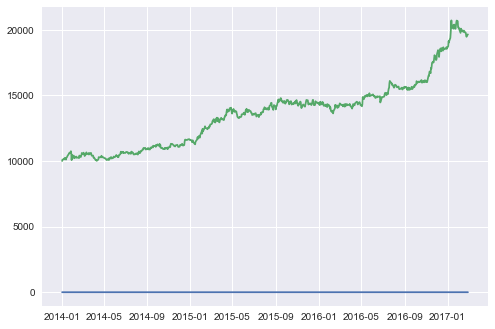

In [32]:
plt.plot(backtrack['MarketValue'])
plt.show()

In [33]:
pf.create_returns_tear_sheet(new)

Entire data start date: 2014-01-02
Entire data end date: 2017-02-28


Backtest Months: 37


Performance statistics   Backtest
annual_return                0.24
cum_returns_final            0.96
annual_volatility            0.14
sharpe_ratio                 1.58
calmar_ratio                 3.03
stability_of_timeseries      0.92
max_drawdown                -0.08
omega_ratio                  1.31
sortino_ratio                2.52
skew                         0.22
kurtosis                     2.12
tail_ratio                   1.26
common_sense_ratio           1.56
information_ratio            0.05
alpha                        0.17
beta                         0.48

Worst drawdown periods net drawdown in %  peak date valley date recovery date  \
0                                   7.88 2015-09-15  2016-02-11    2016-05-05   
1                                   6.81 2014-01-27  2014-04-10    2014-08-13   
2                                   6.02 2017-01-12  2017-02-24           NaT   
3                                   5.58 2015-04-27  2015-05-18    2015-07-31   
4                                   4.63 2016-05-24  2016-06-24    2016-07-08   

Worst drawdown periods duration  
0                           168  
1                           143  
2                           NaN  
3                            70  
4                            34



[-0.017 -0.029]


In [34]:
backtrack

MarketValue         Cost  ReturnSeries
2014-01-02  10000.000000  4658.963846      0.000000
2014-01-03  10105.051026  4658.963846      0.010505
2014-01-06  10120.681526  4658.963846      0.001547
2014-01-07  10138.966934  4658.963846      0.001807
2014-01-08  10119.233232  4658.963846     -0.001946
2014-01-09  10213.076456  4658.963846      0.009274
2014-01-10  10240.798768  4658.963846      0.002714
2014-01-13  10105.129280  4658.963846     -0.013248
2014-01-14  10235.004464  4658.963846      0.012852
2014-01-15  10269.373711  4658.963846      0.003358
2014-01-16  10302.934113  4658.963846      0.003268
2014-01-17  10371.359533  4658.963846      0.006641
2014-01-21  10536.586328  4658.963846      0.015931
2014-01-22  10606.297285  4658.963846      0.006616
2014-01-23  10589.614379  4658.963846     -0.001573
2014-01-24  10604.328191  4658.963846      0.001389
2014-01-27  10745.042872  4658.963846      0.013270
2014-01-28  10565.901741  4658.963846     -0.016672
2014-01-29  10066.769224  4658.963846     -0.047240
2014-01-30  10463.931689  4658.963846      0.039453
2014-01-31  10437.945766  4658.963846     -0.002483
2014-02-03  10294.081918  4658.963846     -0.013783
2014-02-04  10410.548823  4658.963846      0.011314
2014-02-05  10209.017834  4658.963846     -0.019358
2014-02-06  10299.927011  4658.963846      0.008905
2014-02-07  10243.487375  4658.963846     -0.005480
2014-02-10  10285.980734  4658.963846      0.004148
2014-02-11  10337.518813  4658.963846      0.005011
2014-02-12  10244.953282  4658.963846     -0.008954
2014-02-13  10251.156713  4658.963846      0.000606
...                  ...          ...           ...
2017-01-17  20345.249049  4658.963846      0.010487
2017-01-18  20082.756886  4658.963846     -0.012902
2017-01-19  20258.618468  4658.963846      0.008757
2017-01-20  20395.139755  4658.963846      0.006739
2017-01-23  20069.652853  4658.963846     -0.015959
2017-01-24  20086.266144  4658.963846      0.000828
2017-01-25  20316.573239  4658.963846      0.011466
2017-01-26  20572.327894  4658.963846      0.012588
2017-01-27  20701.368142  4658.963846      0.006273
2017-01-30  20655.711219  4658.963846     -0.002206
2017-01-31  20190.462337  4658.963846     -0.022524
2017-02-01  20150.011440  4658.963846     -0.002003
2017-02-02  20174.921580  4658.963846      0.001236
2017-02-03  20055.873639  4658.963846     -0.005901
2017-02-06  19845.801932  4658.963846     -0.010474
2017-02-07  19761.706067  4658.963846     -0.004237
2017-02-08  20089.771300  4658.963846      0.016601
2017-02-09  19982.234714  4658.963846     -0.005353
2017-02-10  19901.898714  4658.963846     -0.004020
2017-02-13  19958.155159  4658.963846      0.002827
2017-02-14  19885.001979  4658.963846     -0.003665
2017-02-15  19828.668146  4658.963846     -0.002833
2017-02-16  19854.658353  4658.963846      0.001311
2017-02-17  19927.955185  4658.963846      0.003692
2017-02-21  19759.551980  4658.963846     -0.008451
2017-02-22  19760.668231  4658.963846      0.000056
2017-02-23  19541.132348  4658.963846     -0.011110
2017-02-24  19465.601676  4658.963846     -0.003865
2017-02-27  19639.264819  4658.963846      0.008922
2017-02-28  19641.455929  4658.963846      0.000112

[795 rows x 3 columns]